## Feature Engineering(automatic)
### Import, Read Data

In [13]:
#패키지 불러오기
from sklearn.preprocessing import LabelEncoder
import featuretools as ft   #automated feature engineering을 위해 import
from scipy import stats     #mode(최빈값) 함수를 쓰기위해 import
import pandas as pd
import numpy as np
import os
dicpath = os.getcwd()

#feature engineering 과정에서 쓰는 작업을 모아둔 함수들
def indexer(df):
    df['acc_id'] = df.index.str[1:].astype(str)
    df["trade_week"] = df.index.str[:1].astype(int)
    df = df.fillna(0).reset_index()
    
    if len(df["index"]) != KeyError:
        df = df.drop('index',axis=1)
    
    return df

def flat_colname(df,col_list):
    df.index.name = None
    df.columns = col_list
    df['acc_id'] = df.index
    
    return df

def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [3]:
#데이터 불러오기
#전처리를 위해 train, test data 통합

train_activity = pd.read_csv(dicpath+'/train/train_activity.csv',encoding='EUC-kr')
train_label = pd.read_csv(dicpath+'/train/train_label.csv',encoding='EUC-kr')
train_guild = pd.read_csv(dicpath+'/train/train_guild.csv',encoding='EUC-kr')
train_party = pd.read_csv(dicpath+'/train/train_party.csv',encoding='EUC-kr')
train_payment = pd.read_csv(dicpath+'/train/train_payment.csv',encoding='EUC-kr')
train_trade = pd.read_csv(dicpath+'/train/train_trade.csv',encoding='EUC-kr')

test_activity = pd.read_csv(dicpath+'/test/test_activity.csv',encoding='EUC-kr')
test_guild = pd.read_csv(dicpath+'/test/test_guild.csv',encoding='EUC-kr')
test_party = pd.read_csv(dicpath+'/test/test_party.csv',encoding='EUC-kr')
test_payment = pd.read_csv(dicpath+'/test/test_payment.csv',encoding='EUC-kr')
test_trade = pd.read_csv(dicpath+'/test/test_trade.csv',encoding='EUC-kr')
test_label = pd.DataFrame(test_payment["acc_id"].unique())
test_label.columns = ["acc_id"]

train_label = train_label.append(test_label)
train_activity = train_activity.append(test_activity)
train_guild = train_guild.append(test_guild)
train_party = train_party.append(test_party)
train_payment = train_payment.append(test_payment)
train_trade = train_trade.append(test_trade)

#### 왜 train, test set 합치나요?

- 피처를 변형할 때 test_set이 들어가면서 값이 달라지는 경우가 있음. 예를 들어 정규화를 할 때, 두 방식의 평균과 표준편차가 달라짐

#### 달라지면 성능이 떨어지나요?

- 위 데이터에서 train과 test를 따로 전처리한 모델(1)과 따로 전처리한 모델(2)을 비교한 결과 validation에서는 (1)번 케이스에서 낮은 성능 향상이 일어났지만, Leaderboard의 test 셋에서는 (2)에서 더 높은 f1 score를 보임 -> train, test를 합치면서 overfit이 줄어드는 것으로 보임


### domain knowledge features

In [41]:
#범주형 데이터 레이블 인코딩하기
le = LabelEncoder()

le.fit(train_trade['item_type'])
train_trade['item_type'] = le.transform(train_trade['item_type'])
test_trade['item_type'] = le.transform(test_trade['item_type'])

#완전히 동일한 거래기록 데이터 제거
train_trade = train_trade.drop_duplicates()

#거래 품목 관련 파생데이터(for feature tools)
temp_list = ['target_acc_id','source_acc_id']

for i in range(len(temp_list)):
    
    #구매/판매 아이템 종류에 대한 피처 생성
    train_trade_source_item = train_trade.drop([temp_list[i],'trade_day','trade_time','item_amount'],axis=1)
    imsi_tr = train_trade_source_item.groupby(train_trade_source_item.columns.tolist()).size().reset_index().rename(columns={0:'count'})
    imsi_tr["imsi"] = imsi_tr["trade_week"].map(str) + imsi_tr[temp_list[int(1-i)]]
    imsi_tr = imsi_tr.pivot(index='imsi',columns='item_type',values='count')
    trade_item_list0 = ['acc','cos','gem','gro','mon','wea']
    flat_colname(imsi_tr,trade_item_list0)
    
    if (i == 0):
        train_trade_source_item_type_buy = indexer(imsi_tr)
        print('item_type_buy feature engineered')
    
    elif i == 1:
        train_trade_source_item_type_sell = indexer(imsi_tr)
        print('item_type_sell feature engineered')
    
    #구매/판매 아이템 양에 대한 피처 생성
    train_trade_source_item = train_trade.drop([temp_list[i],'trade_day','trade_time'],axis=1)
    imsi_tr = train_trade_source_item.groupby(train_trade_source_item.columns.tolist()).size().reset_index().rename(columns={0:'count'})
    imsi_tr["imsi"] = imsi_tr["trade_week"].map(str) + imsi_tr[temp_list[int(1-i)]]
    imsi_tr = imsi_tr.drop(['trade_week','count',temp_list[int(1-i)]],axis=1)
    imsi_tr = imsi_tr.groupby(['imsi','item_type']).agg(['sum','min','max','mean']).unstack()
    trade_item_list = ["sum_acc",'sum_cos','sum_gem','sum_gro','sum_mon','sum_wea','min_acc','min_cos','min_gem','min_gro','min_mon','min_wea',"max_acc",'max_cos','max_gem','max_gro','max_mon','max_wea',"mean_acc",'mean_cos','mean_gem','mean_gro','mean_mon','mean_wea']
    flat_colname(imsi_tr,trade_item_list)
    
    if (i == 0):
        train_trade_source_item_amt_buy = indexer(imsi_tr)
        print('item_amt_buy feature engineered')

    elif i == 1:
        train_trade_source_item_amt_sell = indexer(imsi_tr)
        print('item_amt_sell feature engineered')
        
        
#파는 사람의 시간 테이블
train_trade_source_time_01 = train_trade.drop(['target_acc_id','item_type','item_amount'],axis=1)
train_trade_source_time_01.trade_time = train_trade_source_time_01.trade_time.str[:2].astype(int)
train_trade_source_time_sell = train_trade_source_time_01.groupby('source_acc_id').agg({'trade_day':lambda x:stats.mode(x)[0],'trade_time':lambda x:stats.mode(x)[0]})

trade_time_list1 = ['mode_trade_day_sell','mode_trade_time_sell']
flat_colname(train_trade_source_time_sell,trade_time_list1)

#사는 사람의 시간 테이블
train_trade_source_time_01 = train_trade.drop(['source_acc_id','item_type','item_amount'],axis=1)
train_trade_source_time_01.trade_time = train_trade_source_time_01.trade_time.str[:2].astype(int)
train_trade_source_time_buy = train_trade_source_time_01.groupby('target_acc_id').agg({'trade_day':lambda x:stats.mode(x)[0],'trade_time':lambda x:stats.mode(x)[0]})

trade_time_list2 = ['mode_trade_day_buy','mode_trade_time_buy']
flat_colname(train_trade_source_time_buy,trade_time_list2)

train_trade_source_time_sell[['mode_trade_day_sell','mode_trade_time_sell']] = train_trade_source_time_sell[['mode_trade_day_sell','mode_trade_time_sell']].astype(int)
train_trade_source_time_buy[['mode_trade_day_buy','mode_trade_time_buy']] = train_trade_source_time_buy[['mode_trade_day_buy','mode_trade_time_buy']].astype(int)



item_type_buy feature engineered
item_amt_buy feature engineered
item_type_sell feature engineered
item_amt_sell feature engineered


#### 유저별로 아이템을 구매/판매하고 그 종류/양/시간에 대한 데이터 프레임이 발생
- 주차 별 발생한 거래를 aggregate -> 결과는 train_activity와 유사한 frame구조

In [17]:
train_trade_source_item_amt_buy.head(3)

,sum_acc,sum_cos,sum_gem,sum_gro,sum_mon,sum_wea,min_acc,min_cos,min_gem,min_gro,...,max_mon,max_wea,mean_acc,mean_cos,mean_gem,mean_gro,mean_mon,mean_wea,acc_id,trade_week
0,0.0,0.0,0.0,0.000000,-0.012912,0.0,0.0,0.0,0.0,0.000000,...,-0.012912,0.0,0.0,0.0,0.0,0.000000,-0.012912,0.0,0002cb165b57f8ab2bea2e387a3bebcd1ee57b44229150...,1
1,0.0,0.0,0.0,-0.169037,-0.163731,0.0,0.0,0.0,0.0,-0.056346,...,-0.053214,0.0,0.0,0.0,0.0,-0.056346,-0.054577,0.0,00036e5b6a197c196fa10fc0ad4e2853b22294dff64d27...,1
2,0.0,0.0,0.0,-0.169037,-0.165629,0.0,0.0,0.0,0.0,-0.056346,...,-0.054945,0.0,0.0,0.0,0.0,-0.056346,-0.055210,0.0,00038d64fb50e6967fa4488c077614ba9509ed0869f0ad...,1


In [19]:
%%time
#파티 관련
#파티 생성, 종료 시간 대 별로 차이가 있을 것이라 생각
#'party_start_time','party_end_time' 변수를 string으로 만들어서 앞의 숫자 2개 = 시 , 3~5 = 분
train_party.party_start_time = train_party.party_start_time.str[:2].astype(int) * 60 + train_party.party_start_time.str[3:5].astype(int)
train_party.party_end_time = train_party.party_end_time.str[:2].astype(int) * 60 + train_party.party_end_time.str[3:5].astype(int)
#파티 인원수 구하기
train_party['party_num'] = ((train_party['hashed'].apply(len)+1)/65).astype(int)
#파티 유지 시간 (날짜가 변경된 경우도 고려)
train_party['party_mtime'] = train_party.party_end_time - train_party.party_start_time
train_party.loc[train_party.party_mtime < 0, 'party_mtime'] = train_party.loc[train_party.party_mtime < 0, 'party_mtime'] + 24*60
#파티 시작하는 시간대
train_party['party_st_cat'] = round(train_party['party_start_time']/60,0).astype(int)
train_party['party_ed_cat'] = round(train_party['party_end_time']/60,0).astype(int)
train_party_ft = train_party.drop(['party_start_time','party_end_time','party_end_week','party_end_day'],axis=1)
#id별로 row를 새로 생성, train_set에 포함된 id로 추출
train_party_ft_exp = explode(train_party_ft.assign(hashed=train_party_ft.hashed.str.split(',')), 'hashed')
train_party_ft_uniq = train_party_ft_exp.query('hashed in @train_label.acc_id')
train_party_ft_uniq[['party_start_day','party_st_cat','party_ed_cat']] = train_party_ft_uniq[['party_start_day','party_st_cat','party_ed_cat']].astype(int)

In [20]:
train_party.head()

,party_start_week,party_start_day,party_start_time,party_end_week,party_end_day,party_end_time,hashed,party_num,party_mtime,party_st_cat,party_ed_cat
0,1,1,554,1,1,581,11fc85879e5ac9d5c83bfba10d73c4c84c154b9f4d9e1d...,6,27,9,10
1,3,3,665,3,3,787,7176c1516207692857535c30a4650b8e8e586af1fed0fd...,6,122,11,13
2,3,6,138,3,6,148,8092e194a750aae539862ed4405f67a6dd5b492e7e57e3...,6,10,2,2
3,4,1,562,4,1,587,4ec597c569b92bd0e1bae4e2a06e13b9657fb81795e194...,12,25,9,10
4,4,5,389,4,5,410,a4b6aea6cb58e43911e7cb7d6c0497197db7c4ed16e1c9...,6,21,6,7


In [94]:
train_party_ft_uniq.head()

,party_start_week,party_start_day,hashed,party_num,party_mtime,party_st_cat,party_ed_cat
2,1,1,9537dfd85f3afe656d736e9950118548d493b05f66c524...,6,27,9,10
5,1,1,831fc4830fc0da35a5c505e5ae7665f0c1cfa5b3df28e9...,6,27,9,10
8,3,3,fa1958e7846690088273f7f55c04bdbee9715ff2d3c085...,6,122,11,13
9,3,3,e2f97c5cb6a71a627eb4590856d47bfb0f80c68ca76429...,6,122,11,13
10,3,3,58425883f8bb54566f91d5a7fca19b4ec6925641337720...,6,122,11,13


#### train_party 에서는 하나의 파티를 기준으로 데이터 프레임이 만들어짐 -> 한 유저에 대한 row가 생기도록 변경
- hashed 컬럼에서 한 파티마다 1~? 명의 인원이 있는데 이 중 train_label에 존재하는 유저에 대해서만 추출

In [61]:
#길드에 가입한 유저 & 길드가 변경된 유저들 리스트
train_guild.columns = ["guild_id","acc_id"]
unique_guild_idx = train_guild.drop_duplicates(subset="acc_id").index.tolist()
guild_idx = train_guild.index.tolist()

unique_list = list(set(guild_idx) - set(unique_guild_idx))
unique_guild_df = train_guild.iloc[unique_list]
train_guild_chng = unique_guild_df.drop_duplicates(subset="acc_id")

- 길드에 가입한 유저 목록, 길드를 변경한 유저 목록으로 칼럼을 2개 생성

In [65]:
#주별 거래 금액
imsi_01 = train_payment.pivot(index="acc_id",columns="payment_week",values="payment_amount")
pay_list = ['pay_w1','pay_w2','pay_w3','pay_w4','pay_w5','pay_w6','pay_w7','pay_w8']
flat_colname(imsi_01,pay_list)
print('weekly trade amount')

weekly trade amount


In [5]:
act_ft_eng=pd.DataFrame({"acc_id":train_activity["acc_id"],"wk":train_activity["wk"]})

#play_time related
temp_pt = np.exp(train_activity["play_time"])
act_ft_eng["npc_exp_div_play_time"] = np.exp(train_activity["npc_exp"])/temp_pt
act_ft_eng["npc_hongmun_div_play_time"] = np.exp(train_activity["npc_hongmun"])/temp_pt
act_ft_eng["quest_exp_div_play_time"] = np.exp(train_activity["quest_exp"])/temp_pt
act_ft_eng["quest_hongmun_div_play_time"] = np.exp(train_activity["quest_hongmun"])/temp_pt
act_ft_eng["item_hongmun_div_play_time"] = np.exp(train_activity["item_hongmun"])/temp_pt
act_ft_eng["game_combat_time_div_play_time"] = np.exp(train_activity["game_combat_time"])/temp_pt
act_ft_eng["get_money_div_play_time"] = np.exp(train_activity["get_money"])/temp_pt
act_ft_eng["normal_chat_div_play_time"] = np.exp(train_activity["normal_chat"])/temp_pt
act_ft_eng["whisper_chat_div_play_time"] = np.exp(train_activity["whisper_chat"])/temp_pt
act_ft_eng["district_chat_div_play_time"] = np.exp(train_activity["district_chat"])/temp_pt
act_ft_eng["party_chat_div_play_time"] = np.exp(train_activity["party_chat"])/temp_pt
act_ft_eng["guild_chat_div_play_time"] = np.exp(train_activity["guild_chat"])/temp_pt
act_ft_eng["faction_chat_div_play_time"] = np.exp(train_activity["faction_chat"])/temp_pt
act_ft_eng["gathering_cnt_div_play_time"] = np.exp(train_activity["gathering_cnt"])/temp_pt
act_ft_eng["making_cnt_div_play_time"] = np.exp(train_activity["making_cnt"])/temp_pt

#cnt_dt related
act_ft_eng["play_time_div_cnt_dt"] = np.exp(train_activity["play_time"])/np.exp(train_activity["cnt_dt"])

#game_combat_time related
act_ft_eng["npc_exp_div_game_combat_time"] = np.exp(train_activity["npc_exp"])/np.exp(train_activity["game_combat_time"])
act_ft_eng["npc_hongmun_div_game_combat_time"] = np.exp(train_activity["npc_hongmun"])/np.exp(train_activity["game_combat_time"])
act_ft_eng["quest_exp_div_game_combat_time"] = np.exp(train_activity["quest_exp"])/np.exp(train_activity["game_combat_time"])
act_ft_eng["quest_hongmun_div_game_combat_time"] = np.exp(train_activity["quest_hongmun"])/np.exp(train_activity["game_combat_time"])
act_ft_eng["item_hongmun_div_game_combat_time"] = np.exp(train_activity["item_hongmun"])/np.exp(train_activity["game_combat_time"])
act_ft_eng["get_money_div_game_combat_time"] = np.exp(train_activity["get_money"])/np.exp(train_activity["game_combat_time"])

#duel related
act_ft_eng["duel_win_div_duel_cnt"] = np.exp(train_activity["duel_win"])/np.exp(train_activity["duel_cnt"])
act_ft_eng["partyb_win_div_partyb_cnt"] = np.exp(train_activity["partybattle_win"])/np.exp(train_activity["partybattle_cnt"])

#raid related
act_ft_eng["cnt_enter_inzone_solo_div_cnt_enter_raid"] = np.exp(train_activity["cnt_enter_inzone_solo"])/np.exp(train_activity["cnt_enter_raid"])
act_ft_eng["cnt_clear_raid_div_cnt_enter_raid"] = np.exp(train_activity["cnt_clear_raid"])/np.exp(train_activity["cnt_enter_raid"])

train_activity = train_activity.merge(act_ft_eng,how="left")


- 플레이 일수(cnt_dt)와 플레이 시간(play_time)가 eda와 feature importance에서 주요한 변수로 잡혀 이를 활용 + 배경지식을 이용해서 파생변수 생성

In [27]:
#categorical로 바꾸기
train_party_ft_uniq[['party_st_cat','party_ed_cat']] = train_party_ft_uniq[['party_st_cat','party_ed_cat']].astype(object)

### Automatic feature generation with 'featuretools'

In [43]:
#Create new entityset
es = ft.EntitySet(id = 'acc_id')

#Create an entity from the client dataframe
es = es.entity_from_dataframe(entity_id = 'label', dataframe = train_label, 
                              index = 'acc_id')

es = es.entity_from_dataframe(entity_id = 'activity', 
                              dataframe = train_activity,
                              make_index = True,
                              index = 'activity_id')

es = es.entity_from_dataframe(entity_id = 'payment', 
                              dataframe = train_payment,
                              make_index = True,
                              index = 'payment_id')

es = es.entity_from_dataframe(entity_id = 'party', 
                              dataframe = train_party_ft_uniq,
                              make_index = True,
                              index = 'party_id')

es = es.entity_from_dataframe(entity_id = 'trade1', 
                              dataframe = train_trade_source_item_type_buy,
                              make_index = True,
                              index = 'trade1_id')

es = es.entity_from_dataframe(entity_id = 'trade2', 
                              dataframe = train_trade_source_item_type_sell,
                              make_index = True,
                              index = 'trade2_id')

es = es.entity_from_dataframe(entity_id = 'trade3', 
                              dataframe = train_trade_source_item_amt_buy,
                              make_index = True,
                              index = 'trade3_id')

es = es.entity_from_dataframe(entity_id = 'trade4', 
                              dataframe = train_trade_source_item_amt_sell,
                              make_index = True,
                              index = 'trade4_id')


In [44]:
# Relationship between label and activity
r_client_previous = ft.Relationship(es['label']['acc_id'], es['activity']['acc_id'])
es = es.add_relationship(r_client_previous)
r_payments = ft.Relationship(es['label']['acc_id'], es['payment']['acc_id'])
es = es.add_relationship(r_payments)
r_payments = ft.Relationship(es['label']['acc_id'], es['party']['hashed'])
es = es.add_relationship(r_payments)
r_payments = ft.Relationship(es['label']['acc_id'], es['trade1']['acc_id'])
es = es.add_relationship(r_payments)
r_payments = ft.Relationship(es['label']['acc_id'], es['trade2']['acc_id'])
es = es.add_relationship(r_payments)
r_payments = ft.Relationship(es['label']['acc_id'], es['trade3']['acc_id'])
es = es.add_relationship(r_payments)
r_payments = ft.Relationship(es['label']['acc_id'], es['trade4']['acc_id'])
es = es.add_relationship(r_payments)
es

Entityset: acc_id
  Entities:
    label [Rows: 140000, Columns: 2]
    activity [Rows: 615954, Columns: 65]
    payment [Rows: 1120000, Columns: 4]
    party [Rows: 30561885, Columns: 8]
    trade1 [Rows: 512109, Columns: 9]
    trade2 [Rows: 240094, Columns: 9]
    trade3 [Rows: 512109, Columns: 27]
    trade4 [Rows: 240094, Columns: 27]
  Relationships:
    activity.acc_id -> label.acc_id
    payment.acc_id -> label.acc_id
    party.hashed -> label.acc_id
    trade1.acc_id -> label.acc_id
    trade2.acc_id -> label.acc_id
    trade3.acc_id -> label.acc_id
    trade4.acc_id -> label.acc_id

#### Entity 구조
- es entity set에서는 8개의 데이터 프레임이 존재하고 유저 아이디를 키값으로 가짐

In [45]:
%%time
# Create new features using specified primitives
features, feature_names = ft.dfs(entityset = es, target_entity = 'label', 
                                 agg_primitives = ['mean','max','min','std','mode']) 

CPU times: user 51min 49s, sys: 1min 44s, total: 53min 34s
Wall time: 14h 6min 24s


In [46]:
features.shape

(140000, 541)

In [48]:
#의미없는 컬럼 제거
train_01 = features.drop(['MEAN(payment.payment_week)','MAX(payment.payment_week)','MIN(payment.payment_week)','STD(payment.payment_week)'
                         ,'MEAN(activity.wk)','MAX(activity.wk)','MIN(activity.wk)','STD(activity.wk)'
                         ,'MEAN(party.party_start_week)','MAX(party.party_start_week)','MIN(party.party_start_week)','STD(party.party_start_week)'
                         ,'MEAN(trade1.trade_week)','MAX(trade1.trade_week)','MIN(trade1.trade_week)','STD(trade1.trade_week)'
                         ,'MEAN(trade2.trade_week)','MAX(trade2.trade_week)','MIN(trade2.trade_week)','STD(trade2.trade_week)'
                         ,'MEAN(trade3.trade_week)','MAX(trade3.trade_week)','MIN(trade3.trade_week)','STD(trade3.trade_week)'
                         ,'MEAN(trade4.trade_week)','MAX(trade4.trade_week)','MIN(trade4.trade_week)','STD(trade4.trade_week)'
                         ],axis=1)
del features
train_01 = train_01.reset_index(level=['acc_id'])

In [71]:
#앞서 생성한 데이터 프레임 병합하기
train_all = train_01.merge(train_guild_uniq,how='left',on='acc_id')\
                    .merge(train_guild_chng,how='left',on='acc_id')\
                    .merge(imsi_01,how='left',on='acc_id')\
                    .merge(train_trade_source_time_sell,how='left',on='acc_id')\
                    .merge(train_trade_source_time_buy,how='left',on='acc_id')\

train_all.fillna(0,inplace=True)
train_all.loc[train_all.guild_id_x != 0,"guild_id_x"] = 1
train_all.loc[train_all.guild_id_y != 0,"guild_id_y"] = 1

- 앞서 만들어 둔 데이터 프레임과 병합하면서 cardinality가 2인 object를 binary로 변경

In [91]:
#train set과 test set 다시 나누기
test_all_n = train_all[train_all.label == 0]
train_all_n = train_all[train_all.label != 0]
print(test_all_n.shape, train_all_n.shape)

(40000, 528) (100000, 528)


In [92]:
#csv파일로 저장
test_all_n=test_all_n.drop('label',axis=1)
train_all_n.to_csv("fin_train_01.csv")
test_all_n.to_csv("fin_test_01.csv")

### modeling

In [83]:
le = LabelEncoder()
train_all_n["label"] = le.fit_transform(train_all_n["label"])

#### 모델링에 쓰인 변수 설명
- num_folds : kfold 교차 검정을 하기 위한 숫자 k
- feats : 모델에 쓰이는 feature 이름
- num_trials : random search 시도 횟수
- num_rounds : 부스팅 횟수
- early_stopping_rounds : 조기 종료 라운드수(200 라운드동안 성능의 향상이 없으면 stop)
- 주요 params
    * colsample_bytree : training 이전에 사용될 컬럼 비율 지정. overfit을 방지하고 속도 개선
    * reg_lambda : L2 regularization
    * reg_alpha : L1 regularization
    
    
#### 모델링에 사용된 loss function
- multi_logloss

In [84]:
%%time
from sklearn.model_selection import ParameterSampler
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
num_folds = 5

# Create arrays and dataframes to store results
feats = [f for f in train_all_n.columns if f not in ['label','acc_id']]
folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

result_c = []


num_trials = 1
num_rounds = 3000
early_stopping_rounds = 200
params = {
    'objective':['multiclass'],
    'num_class':[4],
    'class_weight':['balanced'],
    'boosting':['gbdt'],
    #'min_child_weight': list(np.arange(1,20,1)),
    'colsample_bytree': [0.6],
    #'max_depth': list(np.arange(3,15,1)),
    #'subsample': list(np.arange(0.4,1,0.1))
    'reg_lambda': [10],
    'reg_alpha' : [1]
    #'learning_rate': [0.005,0.01,0.05,0.1],
    #'num_leaves' :list(np.arange(20,55,3)),
}

for trial, param in zip(np.arange(num_trials),list(ParameterSampler(params, n_iter=num_trials))):
    result_b = []
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_all_n[feats], train_all_n['label'])):
        train_x, train_y = train_all_n[feats].iloc[train_idx], train_all_n['label'].iloc[train_idx]
        valid_x, valid_y = train_all_n[feats].iloc[valid_idx], train_all_n['label'].iloc[valid_idx] 
        

        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_eval = lgb.Dataset(valid_x, valid_y, reference=lgb_train)
        
        regressor = lgb.train(param,
                              lgb_train,
                              valid_sets = lgb_eval,
                              num_boost_round = num_rounds,
                              verbose_eval=50,
                              early_stopping_rounds=early_stopping_rounds
                             )

        y_pred = regressor.predict(valid_x)


        max_pred = []
        for i in range(len(y_pred)):
            max_pred.append(np.argmax(y_pred[i]))

        comp_lab = pd.DataFrame({'pred':max_pred,'true':valid_y})

        pr_rc = pd.DataFrame()
        for i in range(len(comp_lab['pred'].value_counts())):
            prec = len(comp_lab[(comp_lab["pred"]==i) & (comp_lab["true"]==i)])/len(comp_lab["pred"][comp_lab["pred"]==i])
            recl = len(comp_lab[(comp_lab["pred"]==i) & (comp_lab["true"]==i)])/len(comp_lab["true"][comp_lab["true"]==i])

            if i == 0:
                pr_rc = pd.DataFrame({"pred":[prec],"recl":[recl]})
            else:
                pr_rc = pr_rc.append(pd.DataFrame({"pred":[prec],"recl":[recl]}))

        f_score = list()
        for i in range(len(pr_rc.index)):
            f_score.append(1/(pr_rc["pred"].tolist()[i]))
            f_score.append(1/(pr_rc["recl"].tolist()[i]))
        ls_result_lgb = 8/sum(f_score)
        
        result_b.append(ls_result_lgb)
    result_c.append(result_b)



Training until validation scores don't improve for 200 rounds.
[50]	valid_0's multi_logloss: 0.695538
[100]	valid_0's multi_logloss: 0.665443
[150]	valid_0's multi_logloss: 0.655192
[200]	valid_0's multi_logloss: 0.648654
[250]	valid_0's multi_logloss: 0.643555
[300]	valid_0's multi_logloss: 0.639112
[350]	valid_0's multi_logloss: 0.636516
[400]	valid_0's multi_logloss: 0.634346
[450]	valid_0's multi_logloss: 0.631969
[500]	valid_0's multi_logloss: 0.630103
[550]	valid_0's multi_logloss: 0.628481
[600]	valid_0's multi_logloss: 0.627419
[650]	valid_0's multi_logloss: 0.626353
[700]	valid_0's multi_logloss: 0.625795
[750]	valid_0's multi_logloss: 0.624823
[800]	valid_0's multi_logloss: 0.624191
[850]	valid_0's multi_logloss: 0.623915
[900]	valid_0's multi_logloss: 0.623419
[950]	valid_0's multi_logloss: 0.623692
[1000]	valid_0's multi_logloss: 0.623485
[1050]	valid_0's multi_logloss: 0.623257
[1100]	valid_0's multi_logloss: 0.623344
[1150]	valid_0's multi_logloss: 0.623153
[1200]	valid_0

In [86]:
###lgb model   feature :alpha 1, lambda 10
print('사용된 feature 개수 : ',len(feats))
print('5-fold CV f-score :',result_c[0],'average score :',np.average(result_c))
print('predict value ratio : ',sum(comp_lab["pred"]==0),sum(comp_lab["pred"]==1),sum(comp_lab["pred"]==2),sum(comp_lab["pred"]==3))

pr_rc = pd.DataFrame()
for i in range(len(comp_lab['pred'].value_counts())):
    prec = len(comp_lab[(comp_lab["pred"]==i) & (comp_lab["true"]==i)])/len(comp_lab["pred"][comp_lab["pred"]==i])
    recl = len(comp_lab[(comp_lab["pred"]==i) & (comp_lab["true"]==i)])/len(comp_lab["true"][comp_lab["true"]==i])
    print("precision : ",prec,", recall : ",recl)
    if i == 0:
        pr_rc = pd.DataFrame({"pred":[prec],"recl":[recl]})
    else:
        pr_rc = pr_rc.append(pd.DataFrame({"pred":[prec],"recl":[recl]}))

f_score = list()
for i in range(len(pr_rc.index)):
    f_score.append(1/(pr_rc["pred"].tolist()[i]))
    f_score.append(1/(pr_rc["recl"].tolist()[i]))
ls_result_lgb = 8/sum(f_score)

사용된 feature 개수 :  526
5-fold CV f-score : [0.7144990178160795, 0.7123451298353255, 0.7093264323893886, 0.71071843986854, 0.7045903703195658] average score : 0.7102958780457799
predict value ratio :  5640 3897 5337 5126
precision :  0.6074468085106383 , recall :  0.6811133200795229
precision :  0.678470618424429 , recall :  0.5231499802136921
precision :  0.766348135656736 , recall :  0.80846016999407
precision :  0.8421771361685525 , recall :  0.8888202594193947


In [95]:
ft_imp = pd.DataFrame({'name':train_all_n.columns[2:],'fi':regressor.feature_importance()}).sort_values("fi",ascending=False)
fi_zero_list = ft_imp[ft_imp.fi == 0].name.tolist()
ft_imp.to_csv('ft_imp_01.csv')

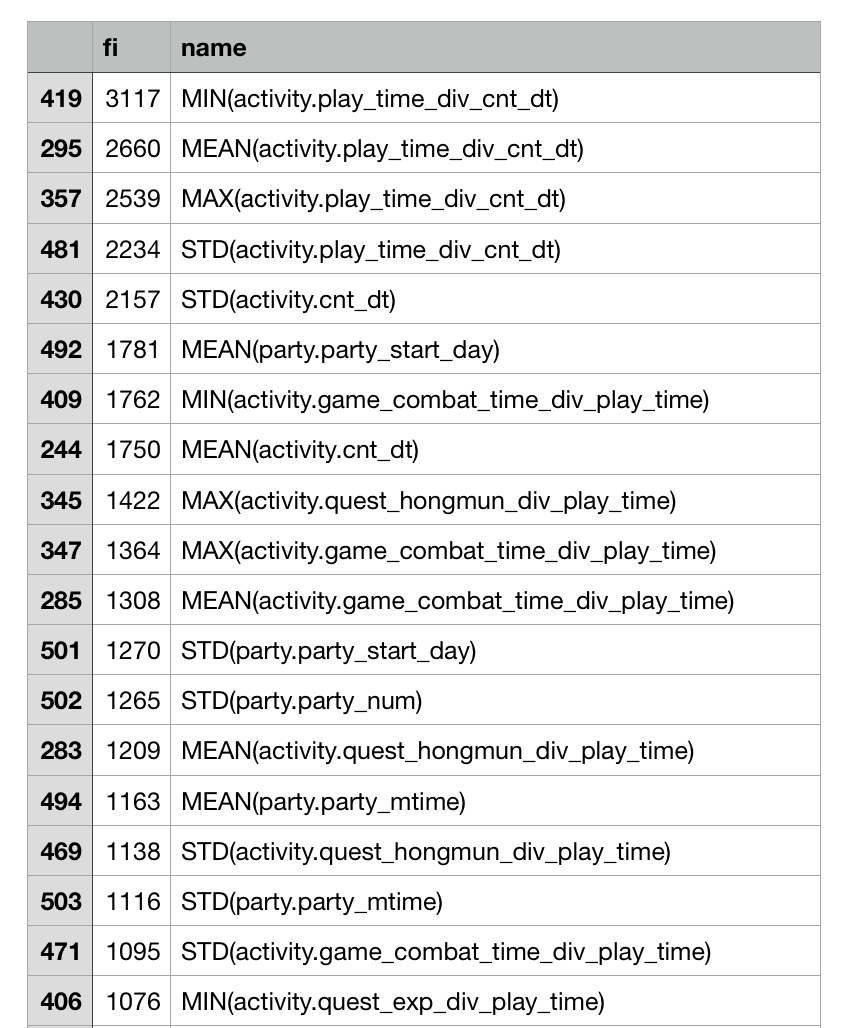

In [101]:
from IPython.display import Image, display
Image('sc8.png')

#### feature importance 가 0인 feature는 제거해야한다?
- 경험적으로는 제거해서 오르는 경우도 있고 떨어지는 경우도 있음. 단, 단순히 모든 0인 컬럼을 제거하면 대부분 성능 저하

In [89]:
import pickle
feature = 'feature_526'
pickle.dump(regressor,open('primal_'+feature+'.pickle','wb'))